# Measuring Point Forecast Error.

**In this lecture you will learn:**
    
* How to partition your time series data into training and test sets
* The definition of a point forecast error
* The difference between scale dependent, relative error and scaled measures
* How to compute some key measures.
* The difference between in-sample and out-of-sample error

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns 
import matplotlib.style as style
style.use('ggplot')

## Load data for this lecture

In [2]:
url = "https://raw.githubusercontent.com/health-data-science-OR/hpdm097-datasets/master/ed_mth_ts.csv"
ed_month = pd.read_csv(url, index_col='date', parse_dates=True)
ed_month.index.freq='MS'
arrival_rate = ed_month['arrivals'] / ed_month.index.days_in_month
arrival_rate.shape

(98,)

# Train-Test Split

Just like in 'standard' machine learning problems it is important to seperate the data used for model training and model testing.  A key difference with time series forecasting is that you must take the temporal ordering of data into account. 

The good news is that pandas makes train test split of data very simple.  There are two options:

1. Split the dataframe using `DataFrame.iloc[start:end]` 
2. Split the dataframe using dates.

**Method 1:**

In [3]:
arrival_rate.shape[0]

98

In [4]:
train_length = arrival_rate.shape[0] - 12
train, test = arrival_rate.iloc[:train_length], arrival_rate.iloc[train_length:]

In [5]:
train.shape

(86,)

In [6]:
test.shape

(12,)

**Method 2:**

In [7]:
SPLIT_DATE = '2016-06-01'
train = arrival_rate.loc[arrival_rate.index < SPLIT_DATE]
test = arrival_rate.loc[arrival_rate.index >= SPLIT_DATE]

In [8]:
train.shape

(86,)

In [9]:
test.shape

(12,)

### IMPORTANT - DO NOT LOOK AT THE TEST SET!

We need to **hold back** a proportion of our data.  This is so we can simulate real forecasting conditions and check a models accuracy on **unseen** data.  We don't want to know what it looks like as that will introduce bias into the forecasting process and mean we overfit our model to the data we hold.

**Remember - there is no such thing as real time data from the future!**

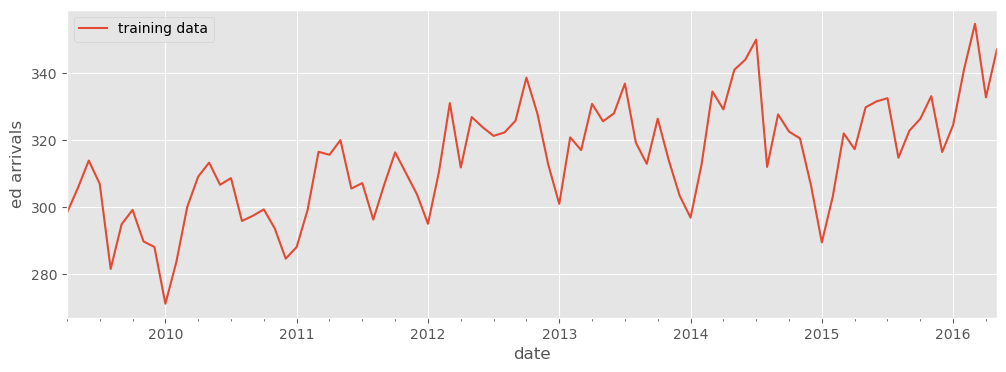

In [10]:
ax = train.plot(figsize=(12,4))
ax.set_ylabel('ed arrivals')
ax.legend(['training data'])

# Point Forecasts

The numbers we produced using the baseline methods in the last lecture are called **point forecasts**.  They are actually the mean value of a **forecast distribution**.  As a reminder:


In [11]:
from forecast_tools.baseline import SNaive

In [12]:
snf = SNaive(period=12)
snf.fit(train)
preds = snf.predict(horizon=12)
preds

array([331.53333333, 332.48387097, 314.74193548, 322.8       ,
       326.35483871, 333.1       , 316.4516129 , 324.51612903,
       341.13793103, 354.67741935, 332.73333333, 347.        ])

The values in `preds` are point forecasts.  For the time being we will focus on point forecasts.  We will revisit forecast distributions in a future lecture.

## Point Forecast Errors

The point forecast is our best estimate of future observations of the time series.  We use our test set (sometimes called a holdout set) to simulate real world forecasting.  As our forecasting method has not seen this data before we can measure the difference between the forecast and the ground-truth observed value.  

> **Problem: Errors can be both positive and negative so just taking the average will mask the true size of the errors.**  

* There are a large number of forecast error metrics available.  Each has its own pro's and con's.  Here we review some of the most used in practice.

### MAE and MSE

* A simple way to remedy the problem with the average error is to use **Mean Absolute Error (MAE)** or **Mean Squared Error (MSE)**.  
* There's a bit of a debate about if you should take the median value or the mean, but here we will just use the mean.

In [13]:
from forecast_tools.metrics import mean_squared_error, mean_absolute_error

In [14]:
mean_squared_error(y_true=test, y_pred=preds)

284.8218020373565

In [15]:
mean_absolute_error(y_true=test, y_pred=preds)

15.130823489944726

### RMSE

* Mean absolute error is conceptually easier to understand than MSE. 
    * In this example, the dimensions of MSE are patients squared!  Which is odd!  
* One way to remedy this units issue is the **Root Mean Squared Error (RMSE)**

RMSE = $\sqrt{mean(e_t^2)}$ where $e_t$ is the error in predicting $y_t$.

You can either calculates this manually or import from `forecast_tools.metrics`


In [16]:
np.sqrt(mean_squared_error(y_true=test, y_pred=preds))

16.87666442272751

In [17]:
from forecast_tools.metrics import root_mean_squared_error

root_mean_squared_error(y_true=test, y_pred=preds)

16.87666442272751

### MAPE

RMSE and MAE are called 'scale dependent' measures as the units and magnitude are specific to the problem and context.  An alternative approach is to use a scale invariant measure such as the **mean absolute percentage error (MAPE)**

The percentage error is given by $p_t = \frac{100e_t}{y_t}$ where $e_t$ is the error in predicting $y_t$.  

Therefore, MAPE = $mean(|p_t|)$. 

In [18]:
from forecast_tools.metrics import mean_absolute_percentage_error

In [19]:
mean_absolute_percentage_error(y_true=test, y_pred=preds)

4.377221333828852

A limitation of MAPE is that it is inflated when the denominator is small relative to the absolute forecast error (such in the case of outliers or extreme unexpected events). It is also penalises negative errors more than positive errors.  A consequence of this property is that MAPE can lead to selecting a model that tends to under forecast.  The two following examples illustrate the issue. $$APE_{1} = \left| \frac{y_t - \hat{y_t}}{y_t} \right|= \left| \frac{150 - 100}{150} \right| = \frac{50}{150} = 33.33\%$$  

$$APE_{2} = \left| \frac{100 - 150}{100} \right| = \frac{50}{100} = 50\%$$

### sMAPE

Given the symmetry issue with MAPE the **symmetric Mean Absolute Percentage Error (sMAPE)** was introduced.  

sMAPE$=mean(200|y_t− \hat{y_t}|/(y_t+\hat{y_t}))$

Although sMAPE has become increasingly popular, Hyndman and Athanasopoulos point out that sMAPE still has the standard percentage error issue of inflation when the denominator is small and that it is not truely symmetric!

In [20]:
from forecast_tools.metrics import symmetric_mean_absolute_percentage_error

In [21]:
symmetric_mean_absolute_percentage_error(y_true=test, y_pred=preds)

4.486053014203669

### MASE

A good solution to relative forecast error and a comparison across series is offered by the **Mean Absolute Scaled Error (MASE)**.  Conceptually the measure is very simple. We calculate the out-of-sample (forecast) MAE and scale it (divide) by the one-step in-sample MAE of a naive method.  To be clear the in-sample data is our training data.

**MASE Interpretation**: A scaled error of less than 1.0 is better than a naive method at predicting one-step ahead in the training data. A scaled error of greater than one is worse.  We prefer lower values of MASE (below 1.0 is good, but not necessary at all).  We can compare MASE across methods and across time series without the unequally weighted penalities and low denomiator issues of MAPE (and sMAPE).

**MASE Scaling**. For non-seasonal series we scale using Naive1. For seasonal series we scale using Seasonal Naive.

$𝑀𝐴𝑆𝐸 = \dfrac{𝑀𝐴𝐸}{𝑀𝐴𝐸_{𝑖𝑛−𝑠𝑎𝑚𝑝𝑙𝑒,𝑛𝑎𝑖𝑣𝑒}}$

The usage of MASE is slightly different than the other metrics we have encountered so far.  This is because it requires the training data and, if seasonal, the period, in order to calculate the training data naive MAE.

In [22]:
from forecast_tools.metrics import mean_absolute_scaled_error

In [23]:
mean_absolute_scaled_error(y_true=test, y_pred=preds, y_train=train, period=7)

0.8970654786818415

## A note on the difference between in-sample and out-of-sample error.

### In-sample errors

These errors are often called the models **residuals** they represent the difference between the training data (the data the model has seen) and the models fitted values.  For example, let's a look at the residuals of the SNaive model fitted to the ED arrival data and then calculate the in-sample MAE.

In [24]:
snf._fitted.tail(10)

,actual,pred,resid
date,,,
2015-08-01,314.741935,312.032258,2.709677
2015-09-01,322.800000,327.666667,-4.866667
2015-10-01,326.354839,322.548387,3.806452
2015-11-01,333.100000,320.500000,12.600000
2015-12-01,316.451613,306.645161,9.806452
2016-01-01,324.516129,289.516129,35.000000
2016-02-01,341.137931,303.214286,37.923645
2016-03-01,354.677419,322.000000,32.677419
2016-04-01,332.733333,317.300000,15.433333


You can access the predictions via the `fittedvalues` property.  Notice that the first 12 observations to not have a prediction.  This is because of the way SNaive works i.e. carrying forward the previous 12 observations.  You cannot carry forward observations that do not exist!

In [25]:
snf.fittedvalues

date
2009-04-01           NaN
2009-05-01           NaN
2009-06-01           NaN
2009-07-01           NaN
2009-08-01           NaN
                 ...    
2016-01-01    289.516129
2016-02-01    303.214286
2016-03-01    322.000000
2016-04-01    317.300000
2016-05-01    329.774194
Freq: MS, Name: pred, Length: 86, dtype: float64

And access the residuals via the `resid` property

In [26]:
snf.resid

date
2009-04-01          NaN
2009-05-01          NaN
2009-06-01          NaN
2009-07-01          NaN
2009-08-01          NaN
                ...    
2016-01-01    35.000000
2016-02-01    37.923645
2016-03-01    32.677419
2016-04-01    15.433333
2016-05-01    17.225806
Freq: MS, Name: resid, Length: 86, dtype: float64

In [27]:
mean_absolute_error(y_true=train[12:], y_pred=snf.fittedvalues[12:])

11.28266062821124

### Out of sample errors

* Out of sample errors are based on predictions of observations the model has not seen (in the test set).  
* These are the point forecast errors we have already calculated.  
* You should expect the out-of-sample errors to be larger than in-sample errors.

In [28]:
mean_absolute_error(y_true=test, y_pred=preds)

15.130823489944726

## Comparing forecasting methods using a test (holdout) set.

Let's compare the MAE of the methods on the ED dataset.

In [29]:
#convenience function for creating all objects quickly
from forecast_tools.baseline import baseline_estimators

In [30]:
models = baseline_estimators(seasonal_period=12)

In [31]:
models

{'NF1': Naive1(),
 'SNaive': SNaive(period=12),
 'Average': Average(),
 'Drift': Drift(),
 'Ensemble': EnsembleNaive(seasonal_period=12)}

In [32]:
HORIZON = len(test)

print(f'{HORIZON}-Step MAE\n----------')
for model_name, model in models.items():
    model.fit(train)
    preds = model.predict(HORIZON)
    mae = mean_absolute_error(y_true=test, y_pred=preds)
    print(f'{model_name}: {mae:.1f}')

12-Step MAE
----------
NF1: 8.3
SNaive: 15.1
Average: 28.9
Drift: 10.2
Ensemble: 10.2
